![BTS](https://github.com/vfp1/bts-mbds-data-science-foundations-2019/raw/master/sessions/img/Logo-BTS.jpg)

# Session 12: Unsupervised Learning - Other Clustering Algorithms

### Filipa Peleja <filipa.peleja@bts.tech>
### Victor F. Pajuelo Madrigal <victor.pajuelo@bts.tech>

## Classical Data Analysis (19-03-2021)

Open this notebook in Google Colaboratory: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vfp1/bts-cda-2020/blob/main/Session_12/Session_12_Classical_Data_Analysis_OtherClusteringAlgorithms_solved.ipynb)

**Resources (code patched and updated from):**
* Sklearn
* Aurelien Geron's O'Reilly's "Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow"

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Hierarchical Clustering

## Linkage criterion

UUID - #S12BC1

In [2]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

Automatically created module for IPython interactive environment


In [3]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

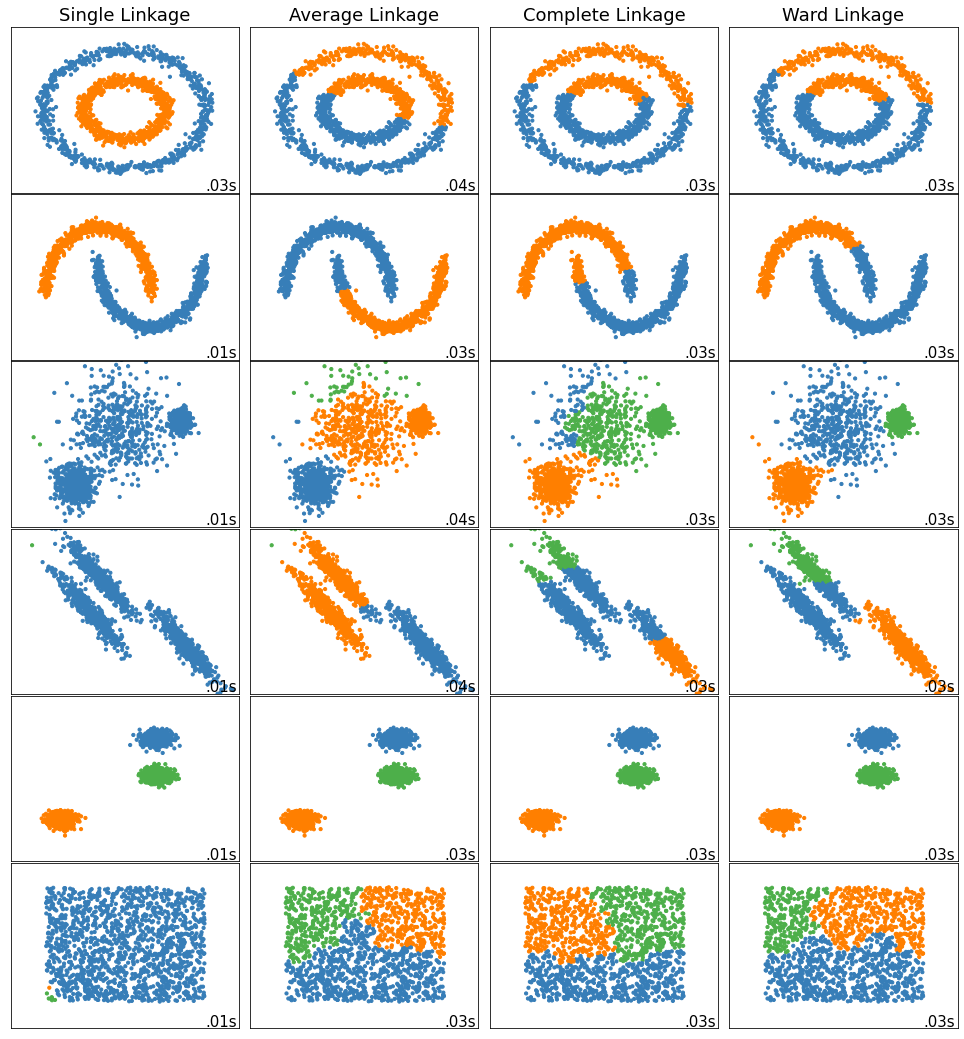

In [4]:
# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {'n_neighbors': 2}),
    (aniso, {'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward')
    complete = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='complete')
    average = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='average')
    single = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='single')

    clustering_algorithms = (
        ('Single Linkage', single),
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

## Usage in sklearn


### Make blob dataset

In [5]:
from sklearn.datasets import make_blobs

In [6]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [7]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [8]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Saving figure blobs_plot


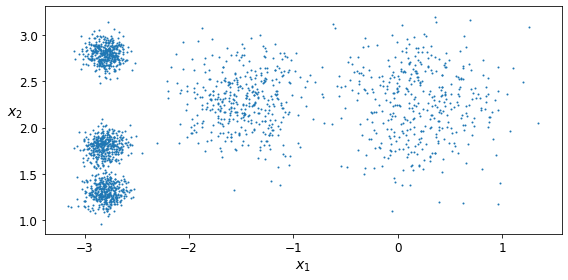

In [9]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

### Using AgglomerativeClustering on blobs

UUID - #S12BC2

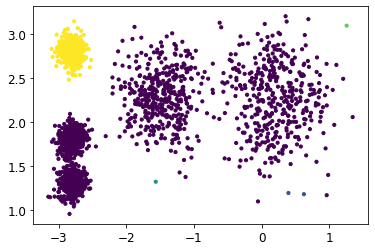

In [10]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=5, linkage='single').fit(X)

labels = clustering.labels_

plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis');

In [19]:
set(list(clustering.labels_))

{0, 1, 2, 3, 4}

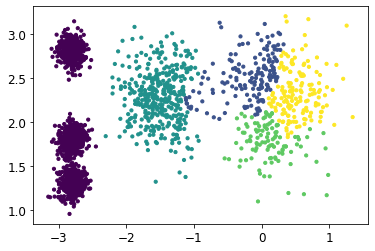

In [11]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=5, linkage='complete').fit(X)

labels = clustering.labels_

plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis');

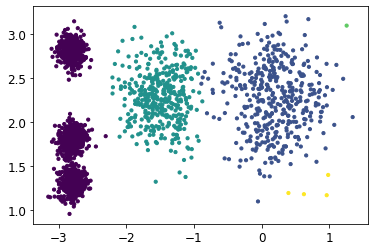

In [12]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=5, linkage='average').fit(X)

labels = clustering.labels_

plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis');

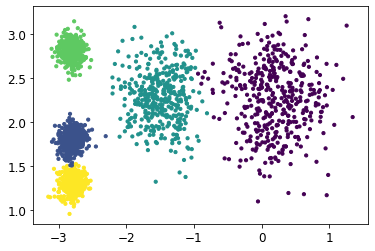

In [13]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(X)

labels = clustering.labels_

plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis');

## Visualization of Hierarchical Clustering

UUID - #S12BC3

### Visualizing clusters

In [14]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram_clusters(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

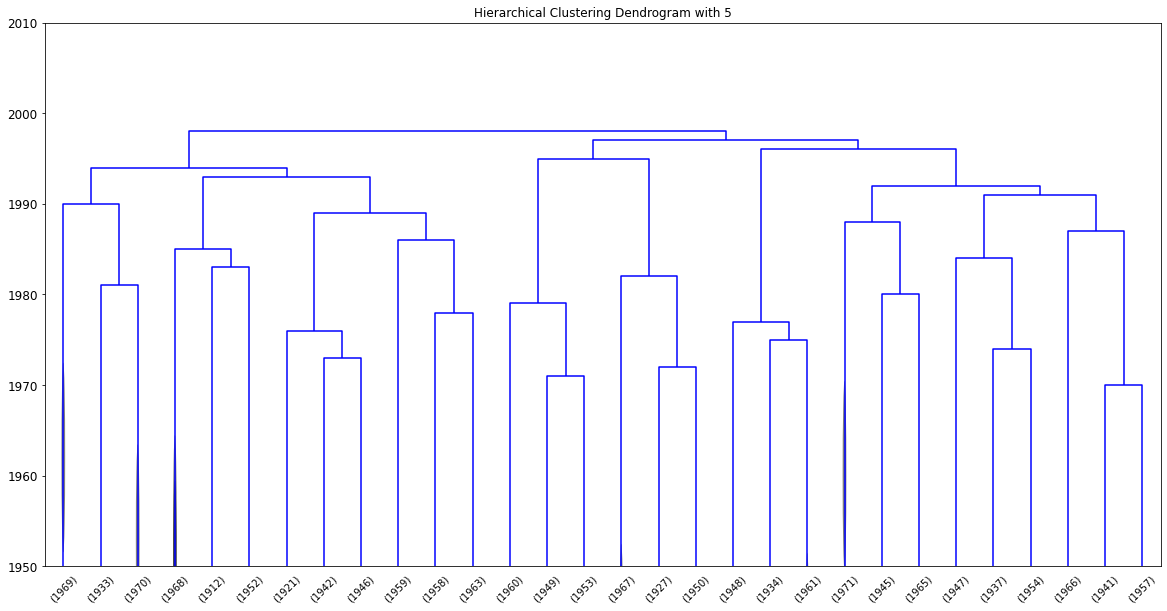

In [16]:
clustering_dendo_1 = AgglomerativeClustering(distance_threshold=None, n_clusters=5, linkage='ward').fit(X)

plt.figure(figsize=(20,10)) 
plt.title('Hierarchical Clustering Dendrogram with {}'.format(clustering_dendo_1.n_clusters))
plot_dendrogram_clusters(model=clustering_dendo_1, labels=clustering_dendo_1.labels_, 
                truncate_mode='lastp', show_contracted=True)
plt.ylim(top=2010)
plt.ylim(bottom=1950)
plt.show()

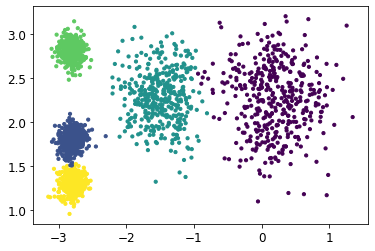

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=clustering_dendo_1.labels_, s=10, cmap='viridis');

### Visualizing distances

In [19]:
def plot_dendrogram_for_distances(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

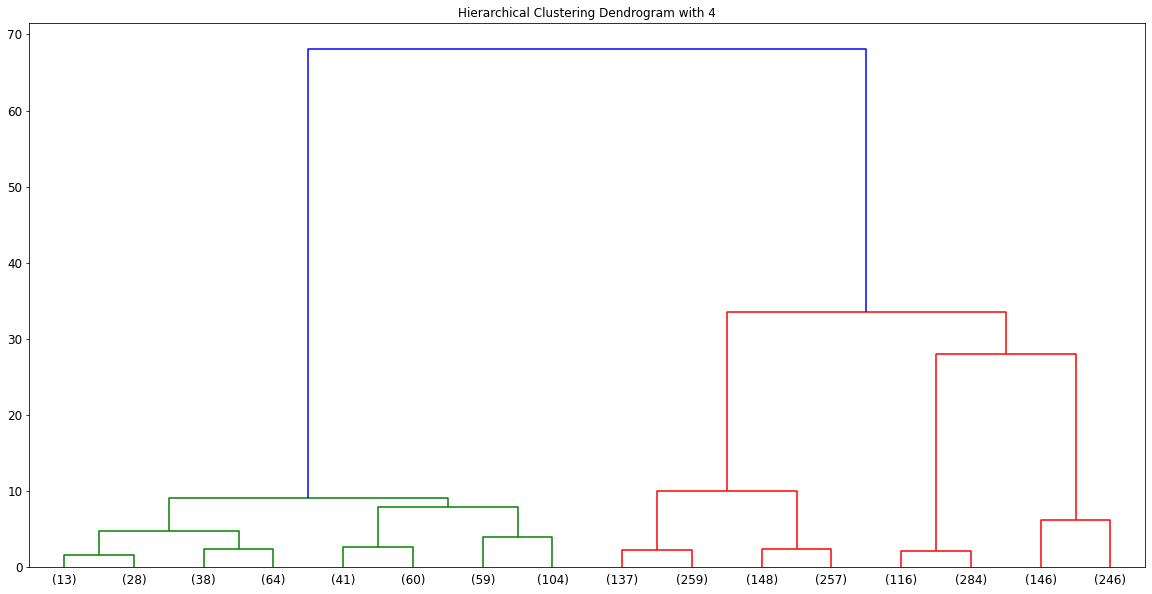

In [20]:
clustering_dendo_2 = AgglomerativeClustering(distance_threshold=10, n_clusters=None, linkage='ward').fit(X)

plt.figure(figsize=(20,10)) 
plt.title('Hierarchical Clustering Dendrogram with {}'.format(clustering_dendo_2.n_clusters_))
plot_dendrogram_for_distances(model=clustering_dendo_2, labels=clustering_dendo_2.labels_, truncate_mode='level', p=3)
plt.show()

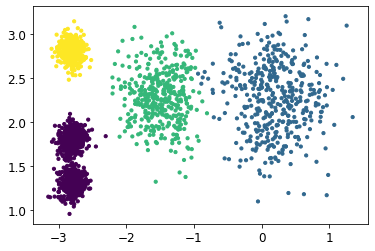

In [22]:
plt.scatter(X[:, 0], X[:, 1], c=clustering_dendo_2.labels_, s=10, cmap='viridis');

## Connectivity constraints

UUID - #S12BC4

### Swiss roll connectivity constraint

Automatically created module for IPython interactive environment
Compute unstructured hierarchical clustering...
Elapsed time: 0.05s
Number of points: 1500
Compute structured hierarchical clustering...
Elapsed time: 0.08s
Number of points: 1500


/Users/pelej4/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass noise=0.05 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


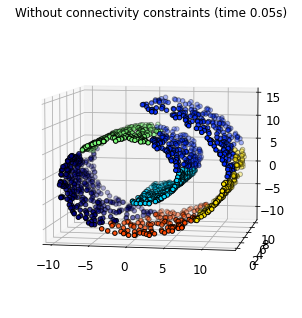

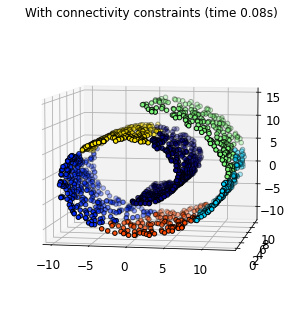

In [23]:
# Authors : Vincent Michel, 2010
#           Alexandre Gramfort, 2010
#           Gael Varoquaux, 2010
# License: BSD 3 clause

print(__doc__)

import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_swiss_roll

# #############################################################################
# Generate data (swiss roll dataset)
n_samples = 1500
noise = 0.05
X, _ = make_swiss_roll(n_samples, noise)
# Make it thinner
X[:, 1] *= .5

# #############################################################################
# Compute clustering
print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

# #############################################################################
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(np.float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('Without connectivity constraints (time %.2fs)' % elapsed_time)


# #############################################################################
# Define the structure A of the data. Here a 10 nearest neighbors
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, connectivity=connectivity,
                               linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

# #############################################################################
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('With connectivity constraints (time %.2fs)' % elapsed_time)

plt.show()

### Connectivity constrains on images

Automatically created module for IPython interactive environment
Compute structured hierarchical clustering...
Elapsed time:  0.2546732425689697
Number of pixels:  4697
Number of clusters:  27


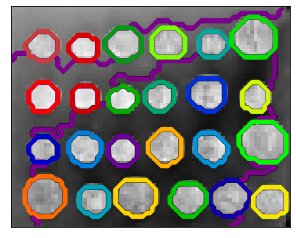

In [24]:
# Author : Vincent Michel, 2010
#          Alexandre Gramfort, 2011
# License: BSD 3 clause

print(__doc__)

import time as time

import numpy as np
from distutils.version import LooseVersion
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt

import skimage
from skimage.data import coins
from skimage.transform import rescale

from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering

# these were introduced in skimage-0.14
if LooseVersion(skimage.__version__) >= '0.14':
    rescale_params = {'anti_aliasing': False, 'multichannel': False}
else:
    rescale_params = {}

# #############################################################################
# Generate data
orig_coins = coins()

# Resize it to 20% of the original size to speed up the processing
# Applying a Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.
smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins = rescale(smoothened_coins, 0.2, mode="reflect",
                         **rescale_params)

X = np.reshape(rescaled_coins, (-1, 1))

# #############################################################################
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*rescaled_coins.shape)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 27  # number of regions
ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                               connectivity=connectivity)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_coins.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label.size)
print("Number of clusters: ", np.unique(label).size)

# #############################################################################
# Plot the results on an image
plt.figure(figsize=(5, 5))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(label == l,
                colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
plt.xticks(())
plt.yticks(())
plt.show()

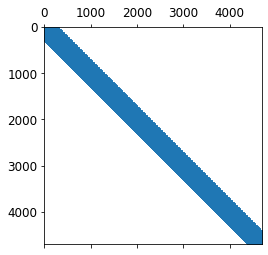

In [25]:
plt.spy(connectivity)

## Hierarchical clustering exercise [EXERCISE 1]

In this example you will be asked to do clustering of a non-linear separable dataset.

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

We have seen already that an important limitation of kmeans is that it assumes all clusters will be linearly separable. Generate a dataset with two moons, generate 200 examples, with `noise=0.05, random_state=0`. Make a scatter plot to visualize the points.

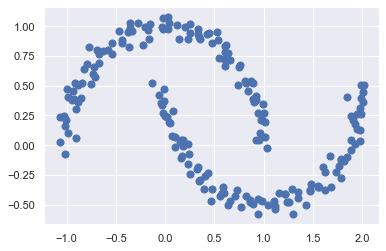

In [27]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis');

## Hierarchical clustering
Import the object `AgglomerativeClustering` to perform hierarchical clustering on this dataset. Try different linkage functions, what do you observe?

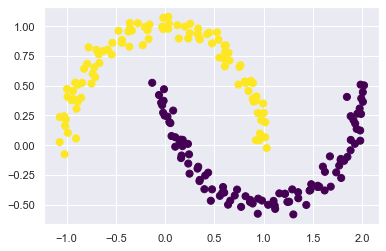

In [28]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage='single').fit(X)

labels = clustering.labels_

plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

Now change the noise factor when generating the dataset, try 0.6, 0.8 and 1. What results do you get?

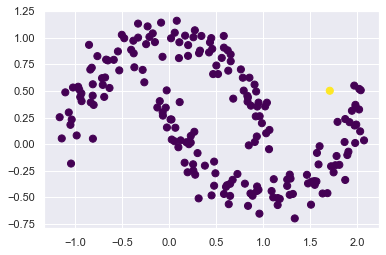

In [29]:
X, y = make_moons(200, noise=.1, random_state=0)

clustering = AgglomerativeClustering(linkage='single').fit(X)

labels = clustering.labels_

plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

Try to find ways to improve the speed using connectivity constraints. Find the best combination of speed/clustering.

# DBSCAN

UUID - #S12BC6

## Make synthetic dataset


In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

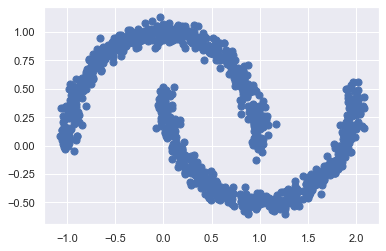

In [31]:
from sklearn.datasets import make_moons
X, y = make_moons(1000, noise=.05, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis');

## Run an easy DBSCAN over it

UUID - #S12BC5

In [32]:
from sklearn.cluster import DBSCAN

clustering_db = DBSCAN(eps=0.05, min_samples=5).fit(X)

Negative cluster indexes reflect the anomalies that the algorithm has considered

In [33]:
clustering_db.labels_

array([ 2,  0,  4, -1,  1,  2,  3,  4,  5,  1,  6,  7,  8,  4,  1,  3,  0,
        4,  3,  4, -1,  6,  5,  5,  0,  8,  3,  4,  8,  9,  0,  8,  1,  8,
        5,  8,  2,  5,  0,  4,  4, -1,  1, -1, -1,  8,  0,  4,  5,  1,  5,
        4,  4,  5,  0,  1,  4,  4, -1,  5,  7,  1,  4,  4,  5,  4,  4, -1,
        4,  7,  8,  4,  8,  4,  0,  5,  5,  8,  1,  1,  4,  5,  5,  2,  0,
        1,  4,  7,  6,  0,  5,  6,  0,  4,  1,  6,  1,  4,  5,  1,  8,  0,
       -1, -1,  5,  1,  1,  8,  2,  4,  4,  1,  5,  7,  4,  5,  7,  5,  6,
        7,  8,  0,  4,  2,  3,  0,  5,  4,  0,  1,  6,  1,  1,  8,  8,  1,
        5,  9,  7,  0,  4,  1,  7,  4,  4,  5,  5,  5,  3,  3,  4,  3,  5,
        8,  2,  2,  5,  5,  0,  6, -1,  2,  1,  0, -1,  5,  5,  2,  5,  5,
        2,  8,  4,  8,  6,  8,  4,  1,  0,  4,  8, -1,  6,  5,  2,  0,  8,
        5,  8,  4,  0,  0,  5,  9,  8,  1,  8,  4,  1,  4,  1,  7,  5,  2,
        0,  1,  8,  7,  7,  2,  4,  1,  3,  0,  0, -1,  4,  4,  3,  1,  8,
        1,  2,  4,  5,  4

In [34]:
clustering_db

DBSCAN(eps=0.05)

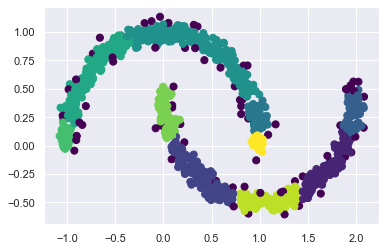

In [35]:
plt.scatter(X[:, 0], X[:, 1], c=clustering_db.labels_, s=50, cmap='viridis');

## Accessing variables

### Get an index of core samples

Those are the indices of the core samples

In [36]:
clustering_db.core_sample_indices_

array([  1,   4,   5,   6,   7,   8,  10,  11,  12,  14,  15,  16,  17,
        18,  19,  21,  22,  23,  24,  25,  26,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  42,  45,  46,  47,  48,
        49,  50,  51,  53,  54,  55,  56,  57,  59,  60,  63,  64,  65,
        66,  68,  71,  73,  74,  76,  77,  78,  80,  81,  82,  83,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 105, 106, 108, 110, 111, 113, 114, 115, 116, 117,
       118, 120, 121, 122, 123, 125, 126, 127, 129, 130, 131, 132, 133,
       134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148,
       149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 161, 162, 163,
       165, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178,
       179, 180, 183, 184, 185, 186, 187, 189, 190, 191, 194, 195, 196,
       198, 200, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 218, 219, 220, 221, 222, 223, 224, 226, 227, 23

## Get a copy of each core sample and its feature

With `components_` we access the core instances themselves

In [37]:
for index, component in zip(clustering_db.core_sample_indices_, clustering_db.components_):
    print(index, component)

1 [ 1.6782009  -0.20198687]
4 [ 0.50484202 -0.3910431 ]
5 [1.96953895 0.36005521]
6 [0.95659588 0.2536649 ]
7 [0.0948788  0.98337847]
8 [-0.4416603   0.87203428]
10 [-1.05224971  0.04748077]
11 [0.07344505 0.18232956]
12 [ 1.32059444 -0.50906259]
14 [0.10374309 0.01069576]
15 [0.89416758 0.34101233]
16 [1.81760764e+00 6.80679015e-04]
17 [0.47521899 0.8195412 ]
18 [1.0278413  0.15987318]
19 [0.82420888 0.48051591]
21 [-0.9701026  0.1342139]
22 [-0.45616265  0.84359244]
23 [-0.37110879  0.93870637]
24 [ 1.74127351 -0.19040108]
25 [ 1.33402957 -0.42155616]
26 [1.03146251 0.22189285]
28 [ 1.05578369 -0.45486009]
29 [0.94627607 0.04333474]
30 [ 1.52276609 -0.38396181]
31 [ 0.79671849 -0.42152371]
32 [ 0.17683409 -0.16157378]
33 [ 1.26086886 -0.53942369]
34 [-0.81980674  0.53939835]
35 [ 0.8910353  -0.50777893]
36 [1.93008419 0.27785691]
37 [-0.67410888  0.71962964]
38 [1.863654   0.06246818]
39 [-0.09480603  0.98642354]
40 [0.14996567 1.05995005]
42 [ 0.35037925 -0.22818795]
45 [ 1.29321621

In [38]:
np.unique(clustering_db.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

## Tweaking the DBSCAN

Our DBSCAN above identified quite a lot of anomalies, plus seven different clusters. How disappointing! We had only two clusters in theory. 

Fortunately, if we widen each instance’s neighborhood by increasing eps to 0.2, we get the clustering on the right, which looks perfect. Let’s continue with this model.

In [39]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

### Utils to plot a nice graph

In [40]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

Saving figure dbscan_plot


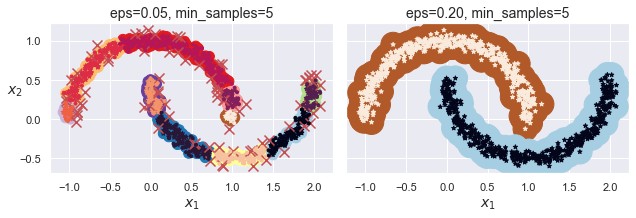

In [41]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(clustering_db, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()

## Where is my fit_predict() !!!!

UUID - #S12C7

The DBSCAN class does not have a `predict()` method, although it has a `fit_predict()` method. 

In other words, it cannot predict which cluster a new instance belongs to. This implementation decision was made because different classification algorithms can be better for different tasks, so the authors decided to let the user choose which one to use. Moreover, it’s not hard to implement. Let's implement a `KNeighborsClassifier` with it.

In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan2.components_, dbscan2.labels_[dbscan2.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

Now if we give some more instances, we can predict in which cluster they are and their probability

In [44]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [45]:
knn.predict_proba(X_new)

array([[0.16, 0.84],
       [1.  , 0.  ],
       [0.16, 0.84],
       [1.  , 0.  ]])

### Plot decision boundaries


In [46]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure cluster_classification_plot


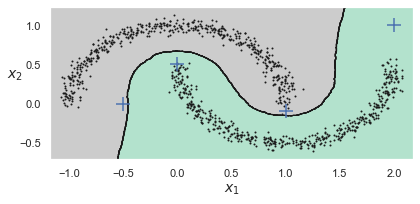

In [47]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

### Predicting anomalies

The decision boundary is represented in the figure above (the crosses represent the four instances in X_new). 

Notice that since there is no anomaly in the training set, the classifier always chooses a cluster, even when that cluster is far away. It is fairly straightforward to introduce a maximum distance, in which case the two instances that are far away from both clusters are classified as anomalies. To do this, use the kneighbors() method of the KNeighborsClassifier. Given a set of instances, it returns the distances and the indices of the k nearest neighbors in the training set (two matrices, each with k columns):

In [48]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan2.labels_[dbscan2.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

## DBSCAN [EXERCISE 2]
Repeat the experiments done with hierarchical clustering, with DBSCAN use `eps=0.3, min_samples=3`

For the case with increased noise, you will have to find a suitable value for `eps`.

A strong drawback for DBSCAN is its high dependency on its parameters.

### Clusters with varying densities

Now let us generate a dataset with clusters that vary in density. Use the `make_blobs` to generate 300 samples. You should generate 3 clusters with std of 1, 2.5 and 0.5 repectively. Use `random_state=1`

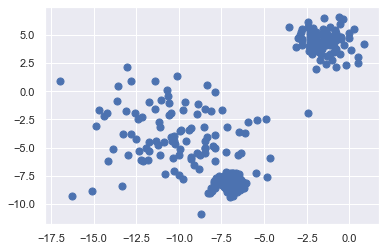

In [51]:
from sklearn import datasets
X, y = datasets.make_blobs(n_samples=300,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=1)

plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis');

Do you clearly distinguish the 3 clusters? Try with AgglomerativeClustering, which linkage function do you think will work the best?

Now use DBSCAN, try several values for `eps`. Is there a value that can separate the clusters properly? 